In [1]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf


os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
from tensorflow.keras.preprocessing import image

from PIL import Image

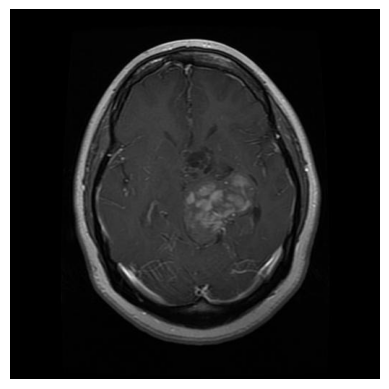

In [2]:
image_path = 'MRI_DATA/Training/tumor/gg (1).jpg'

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Balance the Data Sets

In [10]:
# Image Augmentation to balance the data sets

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

# Define the directory for 'no_tumor' images and where to save augmented images
no_tumor_dir = 'MRI_DATA/Training/no_tumor'
save_dir = 'MRI_DATA/Training/no_tumor'

# Initialize the ImageDataGenerator with your chosen augmentations
augmentation = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Determine the number of augmented images
augmentations_per_image = 6  # 6 * 395 = 2370 augmented images

# List all 'no_tumor' images
no_tumor_images = os.listdir(no_tumor_dir)

# Process and augment each 'no_tumor' image
for img_name in no_tumor_images:
    # Load the image
    img_path = os.path.join(no_tumor_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)  # Reshape
    
    # Initialize a counter for this image
    i = 0
    # Generate augmented images
    for batch in augmentation.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='no_tumor', save_format='jpg'):
        i += 1
        if i >= augmentations_per_image:
            break  # Stop the loop once we hit the target


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width, image_height = 224, 224

# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip inputs horizontally
    validation_split=0.2)  # validation split

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'MRI_DATA/Training/',
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='binary',
        subset='training')  # Set as training data

# Flow validation images in batches using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
        'MRI_DATA/Training/',
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='binary',
        subset='validation')

Found 3991 images belonging to 2 classes.
Found 997 images belonging to 2 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 4
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flattening the 3D output to 1D
    Flatten(),
    
    # Dropout to reduce overfitting
    Dropout(0.5),
    
    # Dense layer for prediction
    Dense(512, activation='relu'),
    
    # Output layer 
    Dense(1, activation='sigmoid')
])

# Printing the model summary to review the architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

In [13]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# training the model

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10
124/124 [==============================] - 133s 1s/step - loss: 0.5138 - accuracy: 0.7638 - val_loss: 0.1888 - val_accuracy: 0.9234
Epoch 2/10
124/124 [==============================] - 108s 869ms/step - loss: 0.2438 - accuracy: 0.9164 - val_loss: 0.2025 - val_accuracy: 0.9143
Epoch 3/10
124/124 [==============================] - 108s 867ms/step - loss: 0.1678 - accuracy: 0.9414 - val_loss: 0.0497 - val_accuracy: 0.9919
Epoch 4/10
124/124 [==============================] - 103s 827ms/step - loss: 0.1173 - accuracy: 0.9596 - val_loss: 0.1042 - val_accuracy: 0.9738
Epoch 5/10
124/124 [==============================] - 106s 852ms/step - loss: 0.1041 - accuracy: 0.9651 - val_loss: 0.1069 - val_accuracy: 0.9587
Epoch 6/10
124/124 [==============================] - 108s 868ms/step - loss: 0.0909 - accuracy: 0.9689 - val_loss: 0.0316 - val_accuracy: 0.9960
Epoch 7/10
124/124 [==============================] - 102s 822ms/step - loss: 0.0768 - accuracy: 0.9732 - val_loss: 0.0151 - va

In [15]:
# rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# create the test_generator
test_generator = test_datagen.flow_from_directory(
    'MRI_DATA/Testing/',
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

# evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f'Test accuracy: {test_acc*100:.2f}%')


Found 409 images belonging to 2 classes.


6/6 [==============================] - 3s 435ms/step - loss: 0.2067 - accuracy: 0.8958
Test accuracy: 89.58%


# Actual test

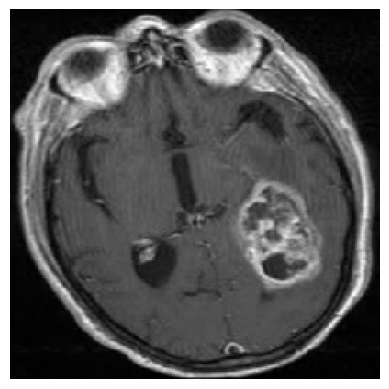

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to specific image
image_path = 'MRI_DATA/Testing/tumor/image(10).jpg'

# Load the image and resize it to match the input shape
img = image.load_img(image_path, target_size=(image_width, image_height))

# Display the loaded image
plt.imshow(img)
plt.axis('off')  # Remove axes for clarity
plt.show()

# Convert the image to a numpy array and rescale
img_array = image.img_to_array(img) / 255.

# Add an extra dimension for the batch size
img_array = np.expand_dims(img_array, axis=0)

In [23]:
# Make predictions
predictions = model.predict(img_array)

# Display the raw prediction value
print(f"Raw prediction score: {predictions[0]}")

# Interpret the prediction score as class labels
predicted_class = 'tumor' if predictions[0] > 0.5 else 'no_tumor'
print(f"Predicted class name: {predicted_class}")

1/1 [==============================] - 0s 24ms/step
Raw prediction score: [0.9984272]
Predicted class name: tumor


In [30]:
model.save('Models/DB_13_89.h5')